In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
ridge = Ridge()
lasso = Lasso()
net   = ElasticNet()
from scipy.stats.stats import pearsonr
%matplotlib inline
from subprocess import check_output
import matplotlib
import sklearn.model_selection as ms
import sklearn
from sklearn.metrics import r2_score

In [2]:
# get data
train = pd.read_csv('WithLogsAndNewFeats.csv')
test = pd.read_csv('test.csv')

In [3]:
# make X and y for train test split
X = train.drop(columns = ['SalePrice'])
y = train["SalePrice"]

In [4]:
# data split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [5]:
alphas3 = np.linspace(1e-3, 200, 50)
gs2 = GridSearchCV(lasso, {"alpha" : alphas3}, cv = 5, iid = True, scoring = "neg_mean_squared_error")
gs2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'alpha': array([1.00000e-03, 4.08261e+00, 8.16422e+00, 1.22458e+01, 1.63274e+01,
       2.04091e+01, 2.44907e+01, 2.85723e+01, 3.26539e+01, 3.67355e+01,
       4.08171e+01, 4.48987e+01, 4.89803e+01, 5.30620e+01, 5.71436e+01,
       6.12252e+01, 6.53068e+01, 6.93884e+01, 7.34700e+01, 7.75... 1.75510e+02, 1.79592e+02,
       1.83674e+02, 1.87755e+02, 1.91837e+02, 1.95918e+02, 2.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [6]:
# optimal alpha
gs2.best_params_

{'alpha': 0.001}

In [7]:
# neg MSE
gs2.best_score_

-0.015310364443821667

Text(0, 0.5, 'rmse')

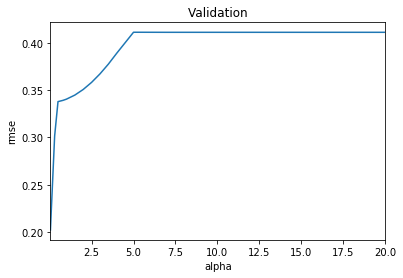

In [8]:
alphas = [0.05, 0.1, 0.3,.5,.8, 1,1.5, 2,2.5, 3,3.5, 4, 5,6,7,8, 10, 20]
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

C:\Users\jdsip\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jdsip\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jdsip\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jdsip\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

RMSE is  0.12294864748178988
Lasso selected 54 variables and eliminated 131 variables


Text(0.5, 1.0, 'Coefficients in the Lasso model')

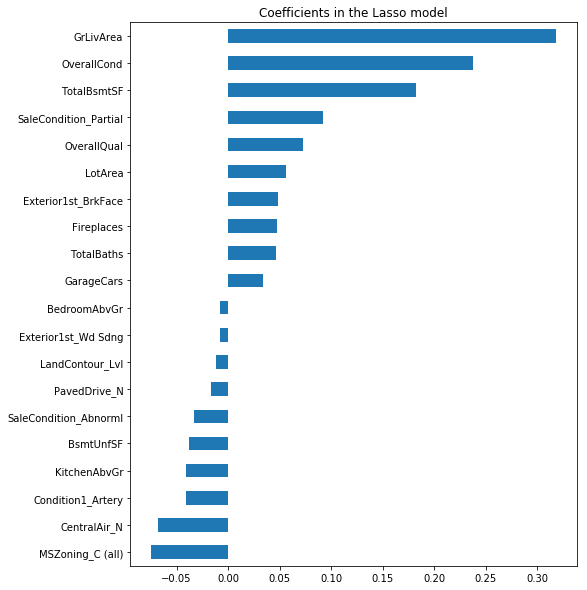

In [9]:
model_lasso = LassoCV(alphas = [0.001]).fit(X_train, y_train)

## calculate test error
print("RMSE is ", rmse_cv(model_lasso).mean())

# coefficients
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print('Lasso selected ' + str(sum(coef != 0)) + ' variables and eliminated ' + str(sum(coef==0)) + ' variables')

# important coefficients 
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

# plot of most important coefficients in the lasso model
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind='barh')
plt.title('Coefficients in the Lasso model') 

In [10]:
## calculate test error
lasso.set_params(alpha = 0.001)
rmse = np.sqrt(-ms.cross_val_score(lasso, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5))
rmse.mean()

0.12294864748178988

In [11]:
# fit model
lasso.set_params(alpha = 0.001, normalize = False)
lasso.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [13]:
# prediction on train
predict_train_lass = lasso.predict(X_train)
print("RMSE on train " , np.sqrt(mean_squared_error(y_train,predict_train_lass)))
print("R2 on train " , r2_score(y_train, predict_train_lass))

# prediction on test
predict_test_lass = lasso.predict(X_test)
print("RMSE on test ", np.sqrt(mean_squared_error(y_test,predict_test_lass)))
print("R2 on test " , r2_score(y_test, predict_test_lass))

RMSE on train  0.11467508824789556
R2 on train  0.9223314642657396
RMSE on test  0.10830734891528122
R2 on test  0.9124634516728583
